In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from my_utils import device, set_random_seed, base_path, plot_stats_path, count_model_params
from my_torch_train import train_epoch, eval_model, train_model

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# setting random seed
set_random_seed(42)

## Load Data

In [4]:
train_dataset = datasets.FashionMNIST(root=f'{base_path}data', train=True, transform=transforms.ToTensor(), download=True)
 
test_dataset = datasets.FashionMNIST(root=f'{base_path}data', train=False, transform=transforms.ToTensor())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)


## Define Models

The general formulas behind one LSTM-cell are as follows:

$$
\begin{align*}
        i &= \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f &= \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g &= \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o &= \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' &= f * c + i * g \\
        h' &= o * \tanh(c') \\
\end{align*}
$$

In [ ]:
class myLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.L_ii = nn.Linear(input_dim, hidden_dim)
        self.L_hi = nn.Linear(hidden_dim, hidden_dim)
        self.L_if = nn.Linear(input_dim, hidden_dim)
        self.L_hf = nn.Linear(hidden_dim, hidden_dim)
        self.L_ig = nn.Linear(input_dim, hidden_dim)
        self.L_hg = nn.Linear(hidden_dim, hidden_dim)
        self.L_io = nn.Linear(input_dim, hidden_dim)
        self.L_ho = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, c, h):
        i = torch.sigmoid(self.L_ii(x) + self.L_hi(h))
        f = torch.sigmoid(self.L_if(x) + self.L_hf(h))
        g = torch.tanh(self.L_ig(x) + self.L_hg(h))
        o = torch.sigmoid(self.L_io(x) + self.L_ho(h))
        c_out = f * c + i*g
        h_out = o * torch.tanh(c_out)
        return c_out, h_out

In [ ]:
class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        
        self.lstm_cells=nn.ModuleList()
        self.lstm_cells.append(myLSTMCell(input_dim, hidden_dim))
        for i in range(num_layers-1):
            self.lstm_cells.append(myLSTMCell(hidden_dim, hidden_dim))
    
    def forward(self, x, hc):
        h = hc[0]
        c = hc[1]
        b_size, n_rows, n_cols = x.shape
        
        for layer in range(self.num_layers):
            new_x = torch.empty((b_size, n_rows, self.hidden_dim)).to(device)
            h_t = h[layer]
            c_t = c[layer]

            for i in range(n_rows):
                c_t, h_t = self.lstm_cells[layer](x[:,i,:], c_t, h_t)
                if n_rows != self.num_layers-1:
                    new_x[:, i, :] = h_t
            x = new_x
        
        return h_t

In [ ]:
class SequentialClassifier(nn.Module):
    """
    Sequential classifier for images. Embedded image rows are fed to a RNN

    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer
        dimensionality of the vectors fed to the LSTM
    hidden_dim: integer
        dimensionality of the states in the cell
    use_own: boolean
        When true uses our LSTM-implementation rather than the one from pytorch
    init_mode: string
        intialization of the states
    num_layers: integer
        the number of LSTM layers the classifier should use
    """

    def __init__(self, input_dim, emb_dim, hidden_dim, use_own=True, init_mode='zeros',
                 num_layers=1):
        """ Module initializer """
        assert init_mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.use_own = use_own

        self.init_mode = init_mode
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)
        
        # lstm model
        if self.use_own:
            self.lstm = myLSTM(input_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers)
        else:
            self.lstm = nn.LSTM(
                input_size=emb_dim, hidden_size=hidden_dim, batch_first=True,
                num_layers=num_layers
            )
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)

        return


    def forward(self, x):
        """ Forward pass through model """

        b_size, n_channels, n_rows, n_cols = x.shape
        h, c = self.init_state(b_size=b_size, device=x.device)

        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)

        # classifying
        if self.use_own:
            lstm_out = self.lstm(embeddings, (h,c))
            y = self.classifier(lstm_out)
        else:
            lstm_out, (h_out, c_out) = self.lstm(embeddings, (h,c))
            y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer

        return y


    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.init_mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
            c = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.init_mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
            c = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.init_mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
            c = self.learned_c.repeat(1, b_size, 1)
        h = h.to(device)
        c = c.to(device)
        return h, c
    


# Training

In [9]:
def train_lstm(model, save_path=None, num_epochs=10):
    # classification loss function
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
    
    train_model(
            model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
            train_loader=train_loader, valid_loader=test_loader, num_epochs=num_epochs,
            save_path=save_path
        )

## Our LSTM with 1 layer

In [ ]:
%%time
own_lstm_1l = SequentialClassifier(input_dim=28, emb_dim=64, hidden_dim=128, 
                                   use_own=True, init_mode="zeros", num_layers=1).to(device)

train_lstm(model=own_lstm_1l, save_path='models/ownLSTM_1layer.pt', num_epochs=10)

Epoch 1/10
    Train loss: 1.21482
    Valid loss: 2.30221
    Accuracy: 16.2%


Epoch 2/10
    Train loss: 0.56707
    Valid loss: 0.6608
    Accuracy: 75.99000000000001%


Epoch 3/10
    Train loss: 0.49299
    Valid loss: 0.53475
    Accuracy: 80.73%


Epoch 4/10
    Train loss: 0.45963
    Valid loss: 0.49806
    Accuracy: 81.69999999999999%


Epoch 5/10
    Train loss: 0.43284
    Valid loss: 0.47862
    Accuracy: 82.63000000000001%


Epoch 6/10
    Train loss: 0.40096
    Valid loss: 0.44523
    Accuracy: 83.58%


Epoch 7/10
    Train loss: 0.39318
    Valid loss: 0.4279
    Accuracy: 84.45%


Epoch 8/10
    Train loss: 0.38978
    Valid loss: 0.4252
    Accuracy: 84.38%


Epoch 9/10
    Train loss: 0.38452
    Valid loss: 0.42349
    Accuracy: 84.44%


Epoch 10/10
    Train loss: 0.38154
    Valid loss: 0.42089
    Accuracy: 84.53%


Training completed
CPU times: user 3min 39s, sys: 1.29 s, total: 3min 41s
Wall time: 3min 41s


In [ ]:
count_model_params(own_lstm_1l)

102474

## pytorch LSTM with 1 layer

In [ ]:
%%time
torch_lstm_1l = SequentialClassifier(input_dim=28, emb_dim=64, hidden_dim=128, 
                                     use_own=False, init_mode="zeros", num_layers=1).to(device)

train_lstm(model=torch_lstm_1l, save_path='models/nnLSTM_1layer.pt')

Epoch 1/10
    Train loss: 1.32824
    Valid loss: 2.30401
    Accuracy: 10.35%


Epoch 2/10
    Train loss: 0.63393
    Valid loss: 0.74451
    Accuracy: 72.99%


Epoch 3/10
    Train loss: 0.52239
    Valid loss: 0.58833
    Accuracy: 77.94%


Epoch 4/10
    Train loss: 0.47092
    Valid loss: 0.49961
    Accuracy: 81.64%


Epoch 5/10
    Train loss: 0.43946
    Valid loss: 0.48435
    Accuracy: 82.27%


Epoch 6/10
    Train loss: 0.40416
    Valid loss: 0.4505
    Accuracy: 83.46000000000001%


Epoch 7/10
    Train loss: 0.39746
    Valid loss: 0.43771
    Accuracy: 83.93%


Epoch 8/10
    Train loss: 0.39237
    Valid loss: 0.42593
    Accuracy: 84.42%


Epoch 9/10
    Train loss: 0.388
    Valid loss: 0.42247
    Accuracy: 84.69%


Epoch 10/10
    Train loss: 0.3848
    Valid loss: 0.41738
    Accuracy: 84.78%


Training completed
CPU times: user 1min 41s, sys: 682 ms, total: 1min 42s
Wall time: 1min 42s


In [ ]:
count_model_params(torch_lstm_1l)

102474

## Our LSTM with 2 layers

In [ ]:
%%time
own_lstm_2l = SequentialClassifier(input_dim=28, emb_dim=64, hidden_dim=128, 
                                     use_own=True, init_mode="zeros", num_layers=2).to(device)

train_lstm(model=own_lstm_2l, save_path='models/ownLSTM_2layer.pt')

Epoch 1/10
    Train loss: 1.11536
    Valid loss: 2.30384
    Accuracy: 10.11%


Epoch 2/10
    Train loss: 0.59283
    Valid loss: 0.65493
    Accuracy: 75.6%


Epoch 3/10
    Train loss: 0.50993
    Valid loss: 0.5548
    Accuracy: 79.02%


Epoch 4/10
    Train loss: 0.46401
    Valid loss: 0.51203
    Accuracy: 80.86%


Epoch 5/10
    Train loss: 0.43289
    Valid loss: 0.47701
    Accuracy: 81.75%


Epoch 6/10
    Train loss: 0.39429
    Valid loss: 0.43718
    Accuracy: 83.86%


Epoch 7/10
    Train loss: 0.38615
    Valid loss: 0.41895
    Accuracy: 84.47%


Epoch 8/10
    Train loss: 0.38103
    Valid loss: 0.41388
    Accuracy: 84.75%


Epoch 9/10
    Train loss: 0.37567
    Valid loss: 0.40885
    Accuracy: 84.89%


Epoch 10/10
    Train loss: 0.37168
    Valid loss: 0.40539
    Accuracy: 84.85000000000001%


Training completed
CPU times: user 5min 46s, sys: 1.73 s, total: 5min 47s
Wall time: 5min 47s


In [ ]:
count_model_params(own_lstm_2l)

234570

## pytorch LSTM with 2 layers

In [ ]:
%%time
torch_lstm_2l = SequentialClassifier(input_dim=28, emb_dim=64, hidden_dim=128, 
                                     use_own=False, init_mode="zeros", num_layers=2).to(device)

train_lstm(model=torch_lstm_2l, save_path='models/nnLSTM_2layer.pt')

Epoch 1/10
    Train loss: 1.11047
    Valid loss: 2.30269
    Accuracy: 9.98%


Epoch 2/10
    Train loss: 0.59069
    Valid loss: 0.64699
    Accuracy: 76.14999999999999%


Epoch 3/10
    Train loss: 0.51761
    Valid loss: 0.58465
    Accuracy: 77.75%


Epoch 4/10
    Train loss: 0.47436
    Valid loss: 0.517
    Accuracy: 80.72%


Epoch 5/10
    Train loss: 0.44221
    Valid loss: 0.48314
    Accuracy: 81.78%


Epoch 6/10
    Train loss: 0.40126
    Valid loss: 0.46371
    Accuracy: 82.72%


Epoch 7/10
    Train loss: 0.39313
    Valid loss: 0.42349
    Accuracy: 84.00999999999999%


Epoch 8/10
    Train loss: 0.38704
    Valid loss: 0.42136
    Accuracy: 84.33%


Epoch 9/10
    Train loss: 0.38009
    Valid loss: 0.41264
    Accuracy: 84.49%


Epoch 10/10
    Train loss: 0.37668
    Valid loss: 0.40891
    Accuracy: 84.86%


Training completed
CPU times: user 1min 50s, sys: 819 ms, total: 1min 51s
Wall time: 1min 51s


In [ ]:
count_model_params(torch_lstm_2l)

234570

# Evaluation

#### training time

layers | own | pytorch
-----|------|------
1 | 3min 39s | 1min 41s  
2 | 5min 46s | 1min 50s

As we can see, the training time of the pytorch implementation is significantly better.

This is because the pytorch library uses underlying C++ code to execute the algorithms and this has a much better performance than our unoptimized python code. 

#### number of parameters

layers | own | pytorch
-----|------|------
1 | 102474 | 102474
2 | 234570 | 234570

We use the same number of parameters as pytorch does.

## nn.LSTM with 1 layer

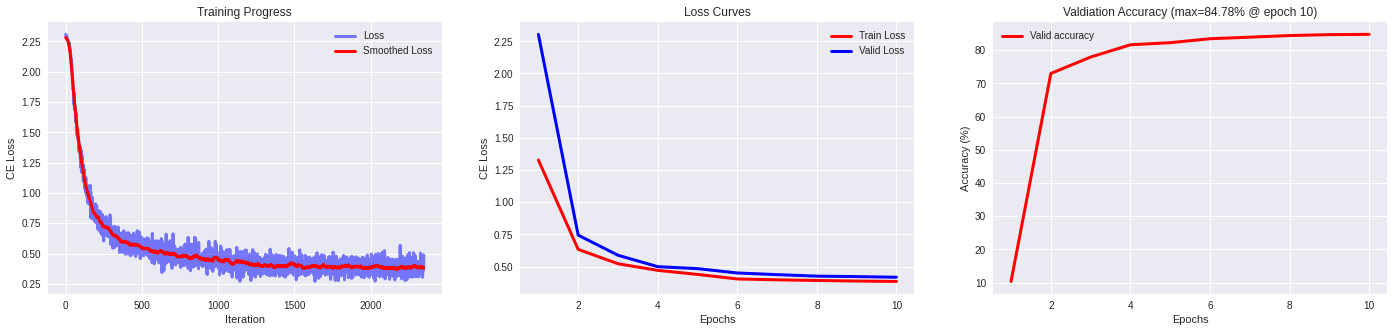

In [ ]:
plot_stats_path('models/nnLSTM_1layer.pt')

## my_LSTM with 1 layer

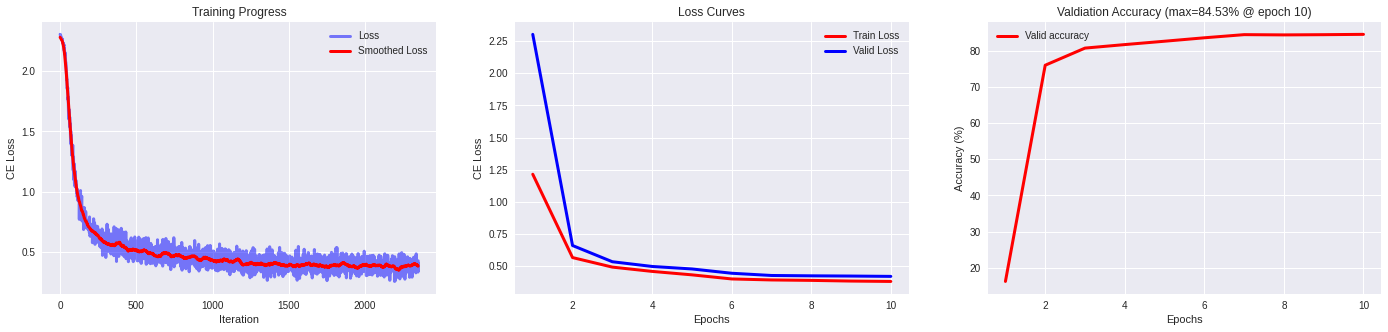

In [ ]:
plot_stats_path('models/ownLSTM_1layer.pt')

## nn.LSTM with 2 layers

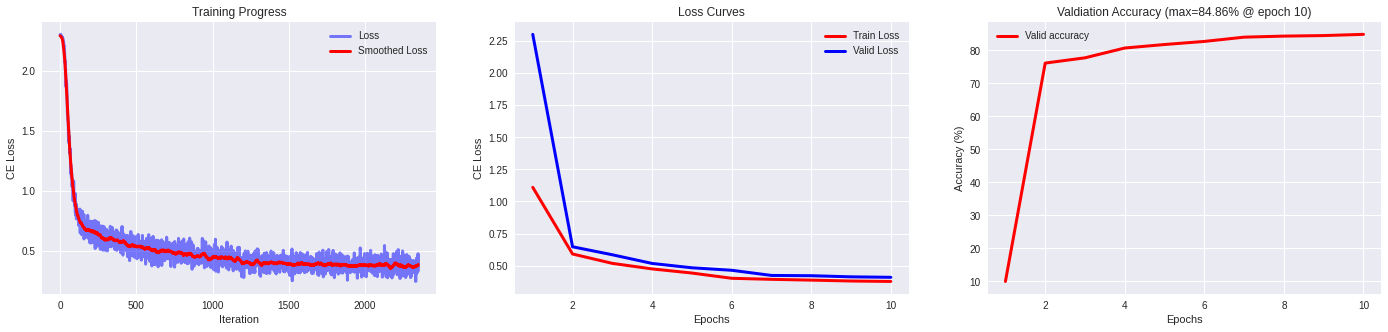

In [ ]:
plot_stats_path('models/nnLSTM_2layer.pt')

## my_LSTM with 2 layers

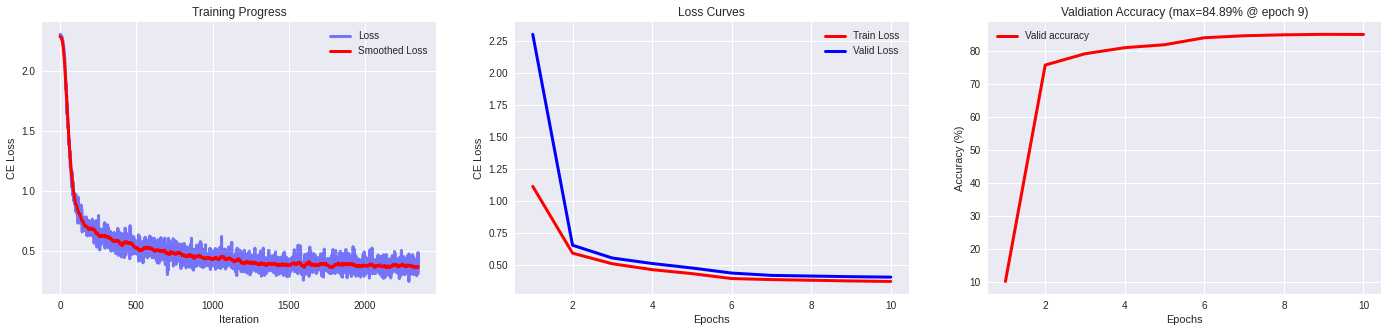

In [ ]:
plot_stats_path('models/ownLSTM_2layer.pt')

As we can see the loss curves are nearly identical for nn.LSTM and my_LSTM for 1 and 2 layers respectively.

In all cases the validation-accuracy gets to 80% after around 4 epochs and stays
at around 84 to 85% in the last epochs.

The best accuracy is achieved by our my_LSTM-implementation with 2 layers (it is 84.89%).
This is most likely due to luck.

# GRU (gated recurrent unit)

### Define models

The general formulas behind one GRU-cell are as follows:

$$\begin{align*}
        r &= \sigma(W_{ir} x + b_{ir} + W_{hr} h + b_{hr}) \\
        z &= \sigma(W_{iz} x + b_{iz} + W_{hz} h + b_{hz}) \\
        n &= \tanh(W_{in} x + b_{in} + r * (W_{hn} h + b_{hn})) \\
        h' &= (1 - z) * n + z * h
\end{align*}
$$

In [2]:
class myGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.L_ir = nn.Linear(input_dim, hidden_dim)
        self.L_hr = nn.Linear(hidden_dim, hidden_dim)
        self.L_iz = nn.Linear(input_dim, hidden_dim)
        self.L_hz = nn.Linear(hidden_dim, hidden_dim)
        self.L_in = nn.Linear(input_dim, hidden_dim)
        self.L_hn = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x, h):
        r = torch.sigmoid(self.L_ir(x) + self.L_hr(h))
        z = torch.sigmoid(self.L_iz(x) + self.L_hz(h))
        n = torch.tanh(self.L_in(x) + r * self.L_hn(h))
        
        h_out = (1-z) * n + z * h
        return h_out

In [3]:
class myGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        
        self.gru_cells=nn.ModuleList()
        self.gru_cells.append(myGRUCell(input_dim, hidden_dim))
        for i in range(num_layers-1):
            self.gru_cells.append(myGRUCell(hidden_dim, hidden_dim))
    
    def forward(self, x, h):
        b_size, n_rows, n_cols = x.shape
        
        for layer in range(self.num_layers):
            new_x = torch.empty((b_size, n_rows, self.hidden_dim)).to(device)
            h_t = h[layer]

            for i in range(n_rows):
                h_t = self.gru_cells[layer](x[:,i,:], h_t)
                if n_rows != self.num_layers-1:
                    new_x[:, i, :] = h_t
            x = new_x
        
        return h_t

In [4]:
class SequentialGRUClassifier(nn.Module):
    """
    Sequential classifier for images using gated recurrent units. 
    Embedded image rows are fed to a GRU

    Args:
    -----
    input_dim: integer
        dimensionality of the rows to embed
    emb_dim: integer
        dimensionality of the vectors fed to the GRU
    hidden_dim: integer
        dimensionality of the states in the cell
    use_own: boolean
        When true uses our GRU-implementation rather than the one from pytorch
    init_mode: string
        intialization of the states
    num_layers: integer
        the number of GRU layers the classifier should use
    """

    def __init__(self, input_dim, emb_dim, hidden_dim, use_own=True, init_mode='zeros',
                 num_layers=1):
        """ Module initializer """
        assert init_mode in ["zeros", "random", "learned"]
        super().__init__()
        self.hidden_dim =  hidden_dim
        self.num_layers = num_layers
        self.use_own = use_own

        self.init_mode = init_mode
        
        # for embedding rows into vector representations
        self.encoder = nn.Linear(in_features=input_dim, out_features=emb_dim)
        
        # gru model
        if self.use_own:
            self.gru = myGRU(input_dim=emb_dim, hidden_dim=hidden_dim, num_layers=num_layers)
        else:
            self.gru = nn.GRU(
                input_size=emb_dim, hidden_size=hidden_dim, batch_first=True,
                num_layers=num_layers
            )
        
        # FC-classifier
        self.classifier = nn.Linear(in_features=hidden_dim, out_features=10)

        return


    def forward(self, x):
        """ Forward pass through model """

        b_size, n_channels, n_rows, n_cols = x.shape
        h = self.init_state(b_size=b_size, device=x.device)

        # embedding rows
        x_rowed = x.view(b_size, n_channels*n_rows, n_cols)
        embeddings = self.encoder(x_rowed)

        # classifying
        if self.use_own:
            h_out = self.gru(embeddings, h)
            y = self.classifier(h_out)
        else:
            h_out, a = self.gru(embeddings, h)
            y = self.classifier(h_out[:, -1, :])

        return y


    def init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.init_mode == "zeros"):
            h = torch.zeros(self.num_layers, b_size, self.hidden_dim)
        elif(self.init_mode == "random"):
            h = torch.randn(self.num_layers, b_size, self.hidden_dim)
        elif(self.init_mode == "learned"):
            h = self.learned_h.repeat(1, b_size, 1)
        h = h.to(device)
        return h

In [10]:
train_gru = train_lstm

## Training of the GRU model

In [14]:
set_random_seed(21)

### Our GRU with 2 layers

In [15]:
%%time
own_gru_2l = SequentialGRUClassifier(input_dim=28, emb_dim=64, hidden_dim=128, 
                                     use_own=True, init_mode="zeros", num_layers=2).to(device)

train_gru(model=own_gru_2l, save_path='models/ownGRU_2layer.pt')

Epoch 1/10
    Train loss: 1.20559
    Valid loss: 2.29554
    Accuracy: 4.78%


Epoch 2/10
    Train loss: 0.59507
    Valid loss: 0.68687
    Accuracy: 74.36%


Epoch 3/10
    Train loss: 0.50137
    Valid loss: 0.56005
    Accuracy: 79.2%


Epoch 4/10
    Train loss: 0.45552
    Valid loss: 0.48743
    Accuracy: 81.69999999999999%


Epoch 5/10
    Train loss: 0.41927
    Valid loss: 0.44373
    Accuracy: 83.56%


Epoch 6/10
    Train loss: 0.39265
    Valid loss: 0.42086
    Accuracy: 84.50999999999999%


Epoch 7/10
    Train loss: 0.38674
    Valid loss: 0.41065
    Accuracy: 85.07000000000001%


Epoch 8/10
    Train loss: 0.38246
    Valid loss: 0.40362
    Accuracy: 85.25%


Epoch 9/10
    Train loss: 0.3776
    Valid loss: 0.40109
    Accuracy: 85.33%


Epoch 10/10
    Train loss: 0.37422
    Valid loss: 0.3944
    Accuracy: 85.7%


Training completed
CPU times: user 3min 27s, sys: 2.27 s, total: 3min 29s
Wall time: 3min 38s


In [16]:
count_model_params(own_gru_2l)

176714

### nn.GRU with 2 layers

In [28]:
set_random_seed(22)

In [29]:
%%time
torch_gru_2l = SequentialGRUClassifier(input_dim=28, emb_dim=64, hidden_dim=128, 
                                       use_own=False, init_mode="zeros", num_layers=2).to(device)

train_gru(model=torch_gru_2l, save_path='models/nnGRU_2layer.pt')

Epoch 1/10
    Train loss: 1.25816
    Valid loss: 2.30471
    Accuracy: 10.26%


Epoch 2/10
    Train loss: 0.63944
    Valid loss: 0.73095
    Accuracy: 72.66%


Epoch 3/10
    Train loss: 0.55056
    Valid loss: 0.60257
    Accuracy: 77.25%


Epoch 4/10
    Train loss: 0.49236
    Valid loss: 0.53364
    Accuracy: 80.33%


Epoch 5/10
    Train loss: 0.45323
    Valid loss: 0.47632
    Accuracy: 82.17999999999999%


Epoch 6/10
    Train loss: 0.42242
    Valid loss: 0.4542
    Accuracy: 83.14%


Epoch 7/10
    Train loss: 0.41666
    Valid loss: 0.43349
    Accuracy: 84.02%


Epoch 8/10
    Train loss: 0.40921
    Valid loss: 0.42866
    Accuracy: 84.11%


Epoch 9/10
    Train loss: 0.40441
    Valid loss: 0.42489
    Accuracy: 84.57000000000001%


Epoch 10/10
    Train loss: 0.39971
    Valid loss: 0.41845
    Accuracy: 84.54%


Training completed
CPU times: user 1min 5s, sys: 404 ms, total: 1min 5s
Wall time: 1min 5s


In [30]:
count_model_params(torch_gru_2l)

176714

## Evaluation of the GRU-models

### training time

own | pytorch
------|------
3min 27s | 1min 5s

Again, the training time of the torch.nn implementation is way faster than ours.

### number of parameters

We use the same number of parameters as the torch.nn implementation, namely 176714 .

## myGRU with 2 layers

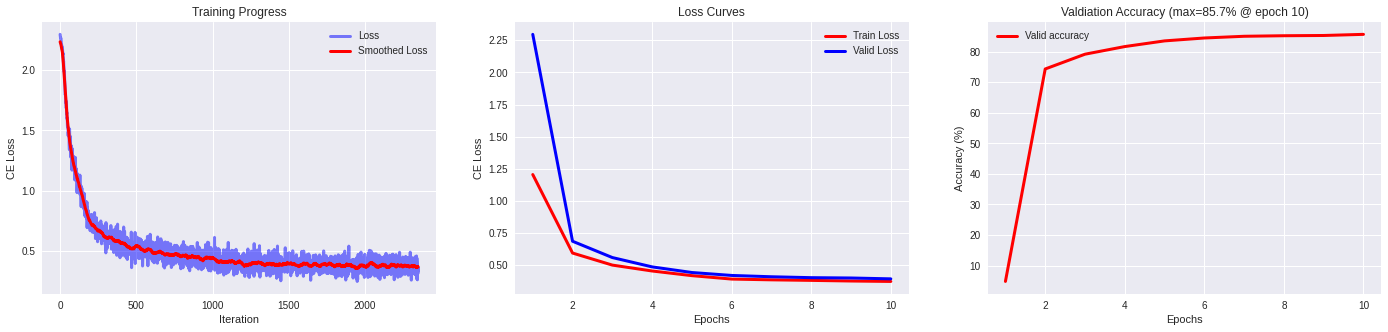

In [5]:
plot_stats_path('models/ownGRU_2layer.pt')

## nn.GRU with 2 layers

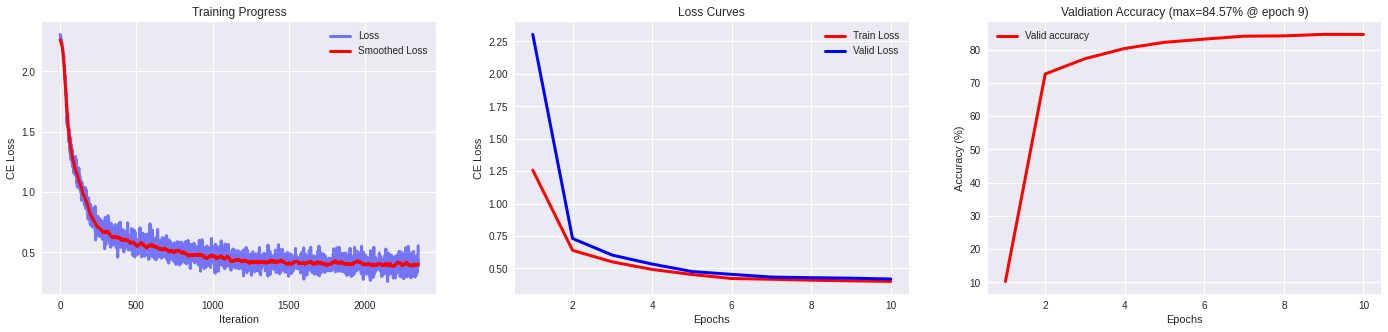

In [7]:
plot_stats_path('models/nnGRU_2layer.pt')

As we can see, the loss-curves again look pretty similar.

Interestingly, the test accuracy is also pretty similiar to the LSTM models though slightly better.
(Here the maximum was 85.7% versus 84.89% in the LSTM model.)

But this could well be due to random effects.